# ARFS - classification

ARFS can be used for classification (binary or multi-class) and for regression. You just have to specify the right loss function.



In [1]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:95% !important; }</style>"))
import numpy as np
import matplotlib.pyplot as plt
import gc
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import arfs
import arfs.feature_selection.allrelevant as arfsgroot
from arfs.feature_selection import (
    MissingValueThreshold,
    UniqueValuesThreshold,
    CollinearityThreshold,
)
from arfs.utils import LightForestClassifier
from arfs.benchmark import highlight_tick, compare_varimp, sklearn_pimp_bench
from arfs.utils import load_data

plt.style.use("fivethirtyeight")
rng = np.random.RandomState(seed=42)

# import warnings
# warnings.filterwarnings('ignore')

In [2]:
print(f"Run with ARFS {arfs.__version__}")

Run with ARFS 3.0.0


In [3]:
import importlib

importlib.reload(arfs)

<module 'arfs' from '/home/bsatom/Documents/arfs/src/arfs/__init__.py'>

In [4]:
gc.enable()
gc.collect()

0

## Simple Usage
In the following examples, I'll use a classical data set to which I added random predictors (numerical and categorical) and a genuine but noisy artificial predictor (correlated to the target). An All Relveant FS methods should discard them.
In the unit tests, you'll find examples using artifical data with genuine (correlated and non-linear) predictors and with some random/noise columns.


In [5]:
# titanic = load_data(name='Titanic')
# X, y = titanic.data, titanic.target

In [6]:
titanic = load_data(name="Titanic")
X, y = titanic.data, titanic.target.cat.codes
cat_f = titanic.categorical

## Leshy

In [7]:
# Let's use lightgbm as booster, see below for using more models
model = LGBMClassifier(random_state=42, verbose=-1)
# model = CatBoostClassifier(random_state=42, verbose=0)
# model = XGBClassifier(random_state=42, verbosity=0)

with native (impurity/Gini) importance

In [8]:
%%time
# Leshy
feat_selector = arfsgroot.Leshy(
    model, n_estimators=20, verbose=1, max_iter=10, random_state=42, importance="native"
)
feat_selector.fit(X_encoded, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

NameError: name 'X_encoded' is not defined

with SHAP importance, original implementation

Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]

/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/sha



Leshy finished running using shap var. imp.

Iteration: 	1 / 10
Confirmed: 	4
Tentative: 	1
Rejected: 	5
All relevant predictors selected in 00:00:02.08
The selected features: ['pclass' 'sex' 'age' 'fare']
The agnostic ranking: [1 1 2 6 6 6 1 4 1 3]
The naive ranking: ['sex', 'pclass', 'age', 'fare', 'embarked', 'random_num', 'family_size', 'is_alone', 'random_cat', 'title']


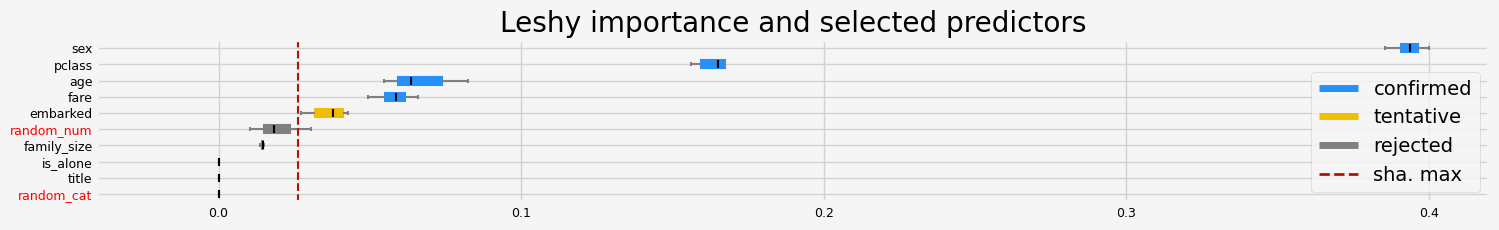

CPU times: user 2.9 s, sys: 125 ms, total: 3.02 s
Wall time: 2.91 s


In [9]:
%%time
# Leshy
model = clone(model)

feat_selector = arfsgroot.Leshy(
    model, n_estimators=5, verbose=1, max_iter=10, random_state=42, importance="shap"
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

the [LinkedIn fasttreeshap](https://engineering.linkedin.com/blog/2022/fasttreeshap--accelerating-shap-value-computation-for-trees) implementation 

In [10]:
# %%time
# # Leshy
# model = clone(model)

# feat_selector = arfsgroot.Leshy(
#     model,
#     n_estimators=50,
#     verbose=1,
#     max_iter=10,
#     random_state=42,
#     importance="fastshap",
# )
# feat_selector.fit(X, y, sample_weight=None)
# print(f"The selected features: {feat_selector.get_feature_names_out()}")
# print(f"The agnostic ranking: {feat_selector.ranking_}")
# print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
# fig = feat_selector.plot_importance(n_feat_per_inch=5)

# # highlight synthetic random variable
# fig = highlight_tick(figure=fig, str_match="random")
# fig = highlight_tick(figure=fig, str_match="genuine", color="green")
# plt.show()

with permutation importance

Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using pimp var. imp.

Iteration: 	1 / 10
Confirmed: 	3
Tentative: 	3
Rejected: 	4
All relevant predictors selected in 00:00:17.74
The selected features: ['pclass' 'sex' 'age']
The agnostic ranking: [1 1 3 5 4 2 1 2 2 6]
The naive ranking: ['sex', 'pclass', 'age', 'family_size', 'title', 'fare', 'embarked', 'is_alone', 'random_cat', 'random_num']


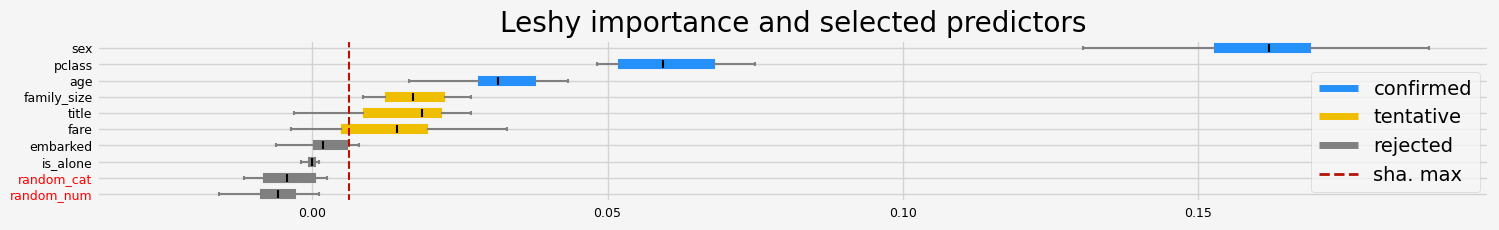

CPU times: user 6.4 s, sys: 293 ms, total: 6.7 s
Wall time: 18.4 s


In [11]:
%%time
# Leshy
model = clone(model)

feat_selector = arfsgroot.Leshy(
    model, n_estimators=50, verbose=1, max_iter=10, random_state=42, importance="pimp"
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

## BoostAGroota

with permutation importance

BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

The selected features: ['pclass' 'sex' 'age' 'family_size']
The agnostic ranking: [2 2 1 1 1 1 2 2 1 1]
The naive ranking: ['sex', 'pclass', 'age', 'family_size', 'fare', 'embarked', 'title', 'random_cat', 'is_alone', 'random_num']


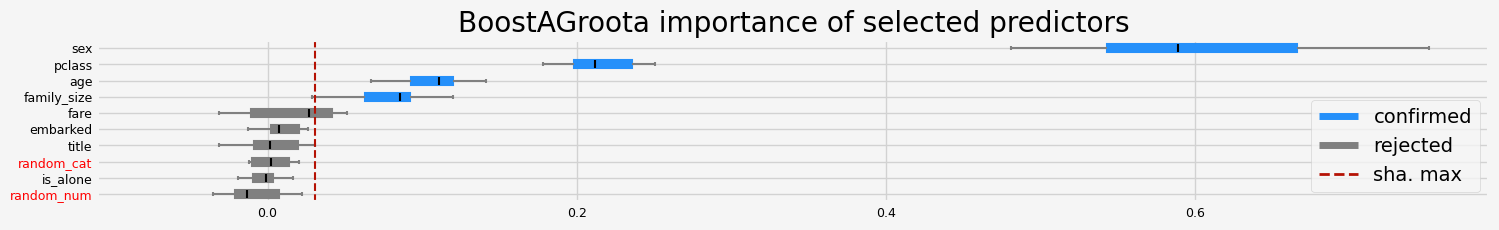

CPU times: user 11.6 s, sys: 440 ms, total: 12 s
Wall time: 19.7 s


In [12]:
%%time

# be sure to use the same but non-fitted estimator
model = clone(model)
# BoostAGroota
feat_selector = arfsgroot.BoostAGroota(
    estimator=model, cutoff=1, iters=10, max_rounds=10, delta=0.1, importance="pimp"
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

with SHAP importance

BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/sha

The selected features: ['pclass' 'sex' 'embarked' 'age' 'fare']
The agnostic ranking: [2 2 2 1 1 1 2 1 2 1]
The naive ranking: ['sex', 'pclass', 'fare', 'age', 'embarked', 'family_size', 'random_num', 'random_cat', 'title', 'is_alone']


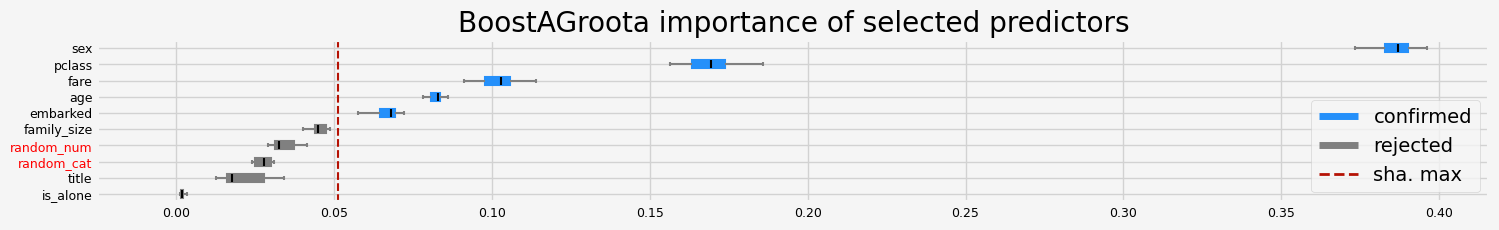

CPU times: user 12.6 s, sys: 382 ms, total: 13 s
Wall time: 7.25 s


In [13]:
%%time

# be sure to use the same but non-fitted estimator
model = clone(model)
# BoostAGroota
feat_selector = arfsgroot.BoostAGroota(
    estimator=model, cutoff=1, iters=10, max_rounds=10, delta=0.1, importance="shap"
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

In [14]:
# %%time

# # be sure to use the same but non-fitted estimator
# model = clone(model)
# # BoostAGroota
# feat_selector = arfsgroot.BoostAGroota(
#     estimator=model, cutoff=1, iters=10, max_rounds=10, delta=0.1, importance="fastshap"
# )
# feat_selector.fit(X, y, sample_weight=None)
# print(f"The selected features: {feat_selector.get_feature_names_out()}")
# print(f"The agnostic ranking: {feat_selector.ranking_}")
# print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
# fig = feat_selector.plot_importance(n_feat_per_inch=5)

# # highlight synthetic random variable
# fig = highlight_tick(figure=fig, str_match="random")
# fig = highlight_tick(figure=fig, str_match="genuine", color="green")
# plt.show()

## GrootCV

Internally, it uses lightGBM and SHAP importance (fast and accurate)

Cross Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.237856	valid_1's binary_logloss: 0.446382


/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[22]	training's binary_logloss: 0.293273	valid_1's binary_logloss: 0.46673


/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[25]	training's binary_logloss: 0.27434	valid_1's binary_logloss: 0.412116


/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[24]	training's binary_logloss: 0.287409	valid_1's binary_logloss: 0.447397


/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[19]	training's binary_logloss: 0.300593	valid_1's binary_logloss: 0.509054
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[43]	training's binary_logloss: 0.183416	valid_1's binary_logloss: 0.412634


/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[20]	training's binary_logloss: 0.305149	valid_1's binary_logloss: 0.463788


/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[15]	training's binary_logloss: 0.348592	valid_1's binary_logloss: 0.480086
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[26]	training's binary_logloss: 0.264479	valid_1's binary_logloss: 0.408829
Training until validation scores don't improve for 20 rounds


/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Early stopping, best iteration is:
[15]	training's binary_logloss: 0.338408	valid_1's binary_logloss: 0.502892
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[18]	training's binary_logloss: 0.323128	valid_1's binary_logloss: 0.474142
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[20]	training's binary_logloss: 0.301777	valid_1's binary_logloss: 0.481132


/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[22]	training's binary_logloss: 0.290578	valid_1's binary_logloss: 0.439708


/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[36]	training's binary_logloss: 0.211251	valid_1's binary_logloss: 0.448651


/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[24]	training's binary_logloss: 0.286865	valid_1's binary_logloss: 0.412533


/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[20]	training's binary_logloss: 0.300983	valid_1's binary_logloss: 0.471764
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[21]	training's binary_logloss: 0.303768	valid_1's binary_logloss: 0.428606
Training until validation scores don't improve for 20 rounds


/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Early stopping, best iteration is:
[21]	training's binary_logloss: 0.2863	valid_1's binary_logloss: 0.501341
Training until validation scores don't improve for 20 rounds


/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Early stopping, best iteration is:
[22]	training's binary_logloss: 0.295479	valid_1's binary_logloss: 0.458821
Training until validation scores don't improve for 20 rounds


/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Early stopping, best iteration is:
[21]	training's binary_logloss: 0.305545	valid_1's binary_logloss: 0.42463
Training until validation scores don't improve for 20 rounds


/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Early stopping, best iteration is:
[37]	training's binary_logloss: 0.210036	valid_1's binary_logloss: 0.404107


/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[31]	training's binary_logloss: 0.241145	valid_1's binary_logloss: 0.454342


/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[37]	training's binary_logloss: 0.207182	valid_1's binary_logloss: 0.441297


/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[18]	training's binary_logloss: 0.309431	valid_1's binary_logloss: 0.495712
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[22]	training's binary_logloss: 0.290437	valid_1's binary_logloss: 0.476951
The selected features: ['pclass' 'sex' 'title' 'age' 'fare']
The agnostic ranking: [2 2 1 1 1 2 2 1 2 1]
The naive ranking: ['ShadowVar10', 'ShadowVar9', 'ShadowVar7', 'ShadowVar4', 'ShadowVar1', 'ShadowVar8', 'ShadowVar6', 'ShadowVar2', 'ShadowVar3', 'ShadowVar5']


/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


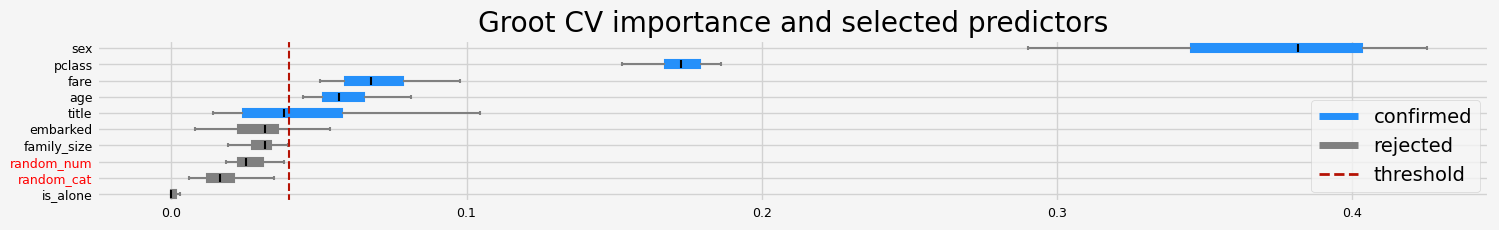

CPU times: user 15.5 s, sys: 1.13 s, total: 16.6 s
Wall time: 6.92 s


In [15]:
%%time
# GrootCV
feat_selector = arfsgroot.GrootCV(
    objective="binary", cutoff=1, n_folds=5, n_iter=5, silent=True, fastshap=False
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

For larger datasets, the fasttreshap implementation can speed up the feature selection process. However, for smaller datasets, the overhead might slightly slow down the process.

In [16]:
# %%time
# # GrootCV
# feat_selector = arfsgroot.GrootCV(
#     objective="binary", cutoff=1, n_folds=5, n_iter=5, silent=True, fastshap=True
# )
# feat_selector.fit(X, y, sample_weight=None)
# print(f"The selected features: {feat_selector.get_feature_names_out()}")
# print(f"The agnostic ranking: {feat_selector.ranking_}")
# print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
# fig = feat_selector.plot_importance(n_feat_per_inch=5)

# # highlight synthetic random variable
# fig = highlight_tick(figure=fig, str_match="random")
# fig = highlight_tick(figure=fig, str_match="genuine", color="green")
# plt.show()

## ARFS in sklearn pipelines

all the selectors (basic, arfs and MRmr) are sklearn compatible and follows the same architecture. Namely, they use the sklearn relevant base classes and therefore have the same methods.

In [17]:
model = clone(model)

# # Leshi/Boruta
# feat_selector = arfsgroot.Leshy(model, n_estimators=50, verbose=1, max_iter=10, random_state=42, importance='shap')

# BoostAGroota
feat_selector = arfsgroot.BoostAGroota(
    estimator=model, cutoff=1, iters=10, max_rounds=10, delta=0.1, importance="shap"
)

# GrootCV
# feat_selector = arfsgroot.GrootCV(objective='binary', cutoff=1, n_folds=5, n_iter=5, silent=True)

arfs_fs_pipeline = Pipeline(
    [
        ("missing", MissingValueThreshold(threshold=0.05)),
        ("unique", UniqueValuesThreshold(threshold=1)),
        ("collinearity", CollinearityThreshold(threshold=0.85)),
        ("arfs", feat_selector),
    ]
)

X_trans = arfs_fs_pipeline.fit(X=X, y=y).transform(X=X)

BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/sha

In [18]:
arfs_fs_pipeline.named_steps["collinearity"].get_feature_names_out()

array(['pclass', 'embarked', 'random_cat', 'is_alone', 'title', 'age',
       'family_size', 'fare', 'random_num'], dtype=object)

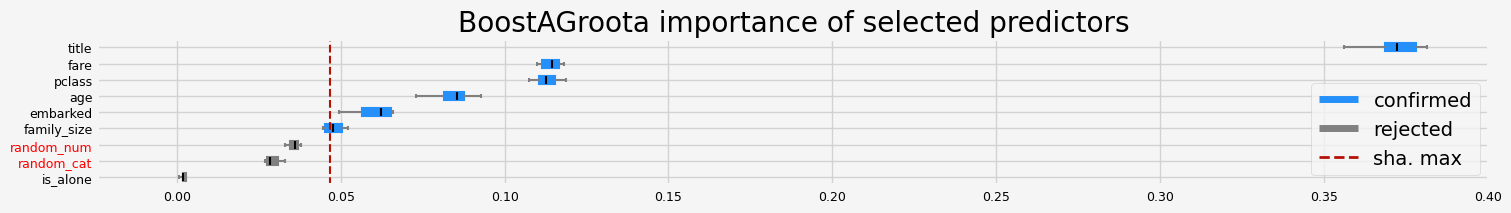

In [19]:
fig = arfs_fs_pipeline.named_steps["arfs"].plot_importance()
# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

## Testing and comparing Leshy, GrootCV and BoostAGroota

In the following examples, I'll use different models which are scikit-learn compatible and then one can compare the different ARFS methods with different models and the different feature importance.
For Leshy (Boruta) and BoostAGroota, the native feature importance (gini/impurity) returns the less reliable results.

==================== Benchmarking using sklearn permutation importance ====================


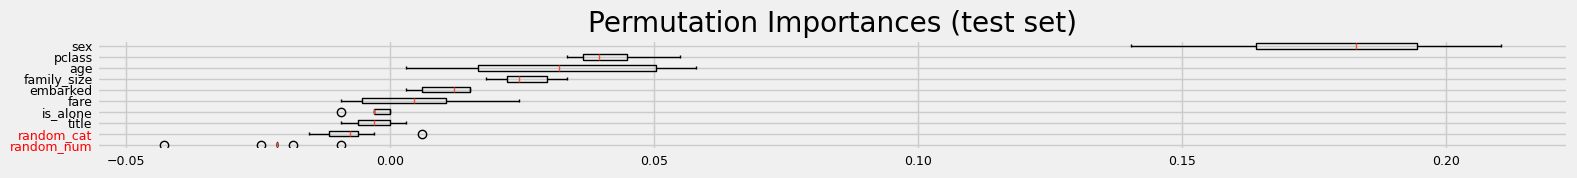

CPU times: user 972 ms, sys: 317 ms, total: 1.29 s
Wall time: 3.49 s


In [20]:
%%time

model = clone(model)
# Benchmark with scikit-learn permutation importance
print("=" * 20 + " Benchmarking using sklearn permutation importance " + "=" * 20)
fig = sklearn_pimp_bench(model, X, y, task="classification", sample_weight=None)

In [21]:
model.__class__.__name__

'LGBMClassifier'

### Testing Leshy

==================== Leshy - testing:        CatBoostClassifier for var.imp: shap            ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using shap var. imp.

Iteration: 	1 / 10
Confirmed: 	5
Tentative: 	2
Rejected: 	3
All relevant predictors selected in 00:00:01.57
['pclass' 'sex' 'age' 'family_size' 'fare']


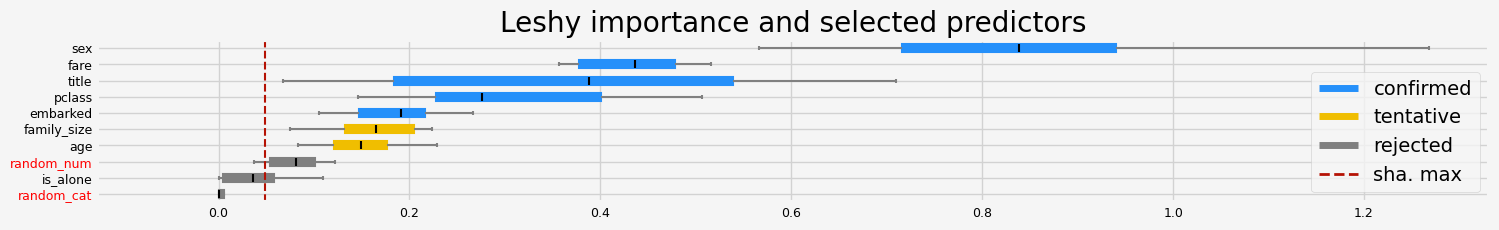

==================== Leshy - testing:        CatBoostClassifier for var.imp: pimp            ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using pimp var. imp.

Iteration: 	1 / 10
Confirmed: 	4
Tentative: 	2
Rejected: 	4
All relevant predictors selected in 00:00:07.61
['pclass' 'sex' 'age' 'family_size']


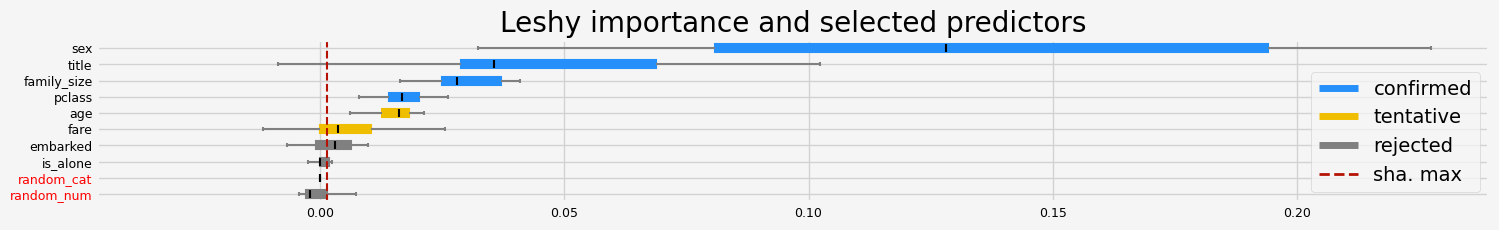

==================== Leshy - testing:        CatBoostClassifier for var.imp: native          ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	4
Tentative: 	3
Rejected: 	3
All relevant predictors selected in 00:00:00.89
['pclass' 'sex' 'title' 'family_size']


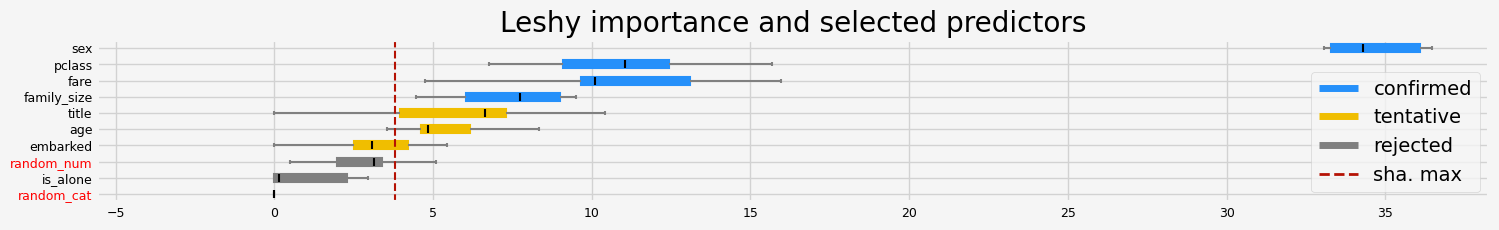

==================== Leshy - testing:            LGBMClassifier for var.imp: shap            ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]

/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/sha



Leshy finished running using shap var. imp.

Iteration: 	1 / 10
Confirmed: 	4
Tentative: 	1
Rejected: 	5
All relevant predictors selected in 00:00:00.91
['pclass' 'sex' 'age' 'fare']


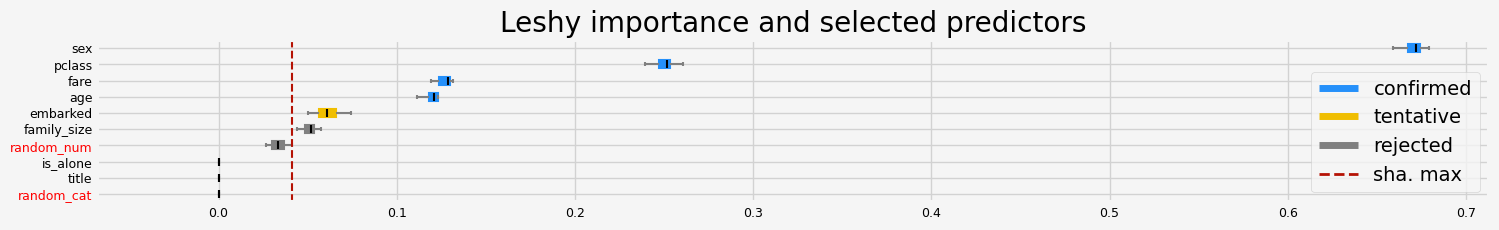

==================== Leshy - testing:            LGBMClassifier for var.imp: pimp            ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using pimp var. imp.

Iteration: 	1 / 10
Confirmed: 	4
Tentative: 	1
Rejected: 	5
All relevant predictors selected in 00:00:05.33
['pclass' 'sex' 'age' 'family_size']


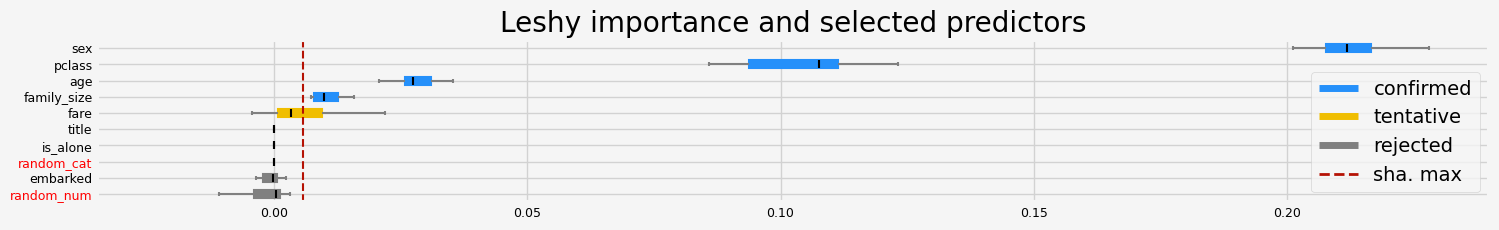

==================== Leshy - testing:            LGBMClassifier for var.imp: native          ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	4
Tentative: 	1
Rejected: 	5
All relevant predictors selected in 00:00:00.53
['pclass' 'sex' 'age' 'fare']


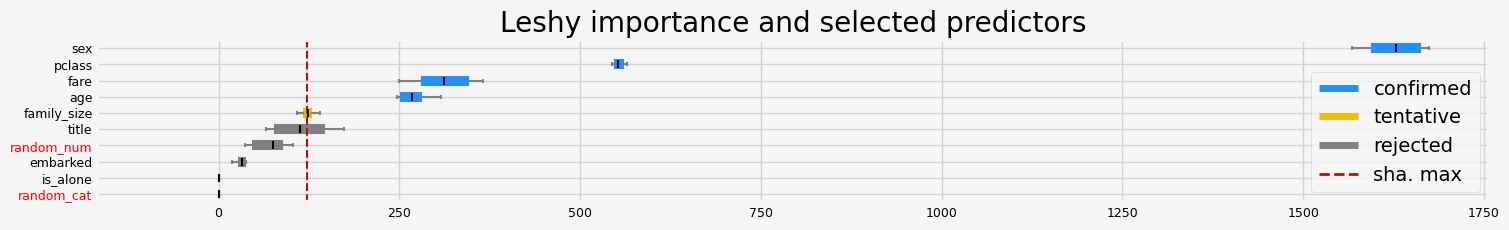

==================== Leshy - testing:            LGBMClassifier for var.imp: shap            ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]

/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/sha



Leshy finished running using shap var. imp.

Iteration: 	1 / 10
Confirmed: 	1
Tentative: 	7
Rejected: 	2
All relevant predictors selected in 00:00:00.65
['title']


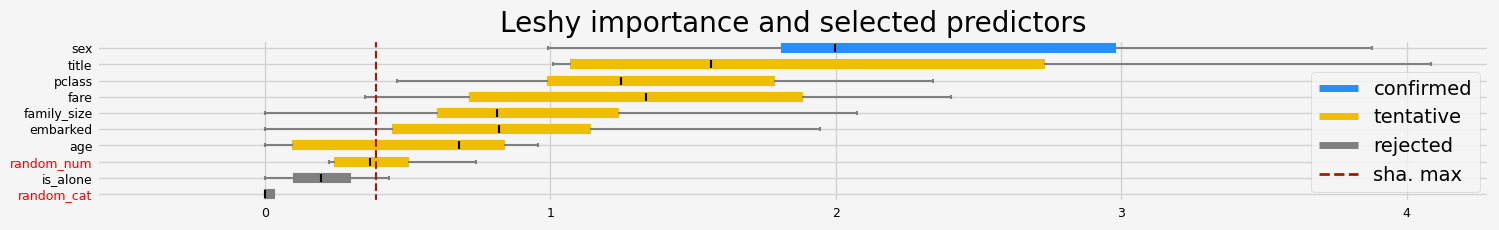

==================== Leshy - testing:            LGBMClassifier for var.imp: pimp            ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using pimp var. imp.

Iteration: 	1 / 10
Confirmed: 	1
Tentative: 	5
Rejected: 	4
All relevant predictors selected in 00:00:05.10
['pclass']


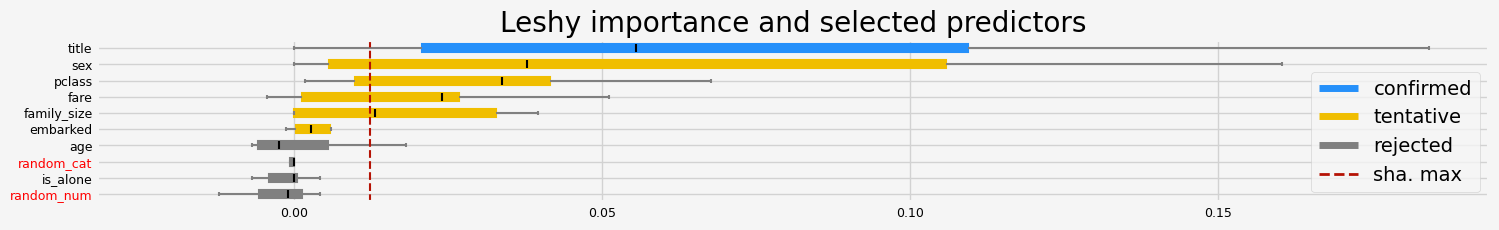

==================== Leshy - testing:            LGBMClassifier for var.imp: native          ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	1
Tentative: 	5
Rejected: 	4
All relevant predictors selected in 00:00:00.52
['sex']


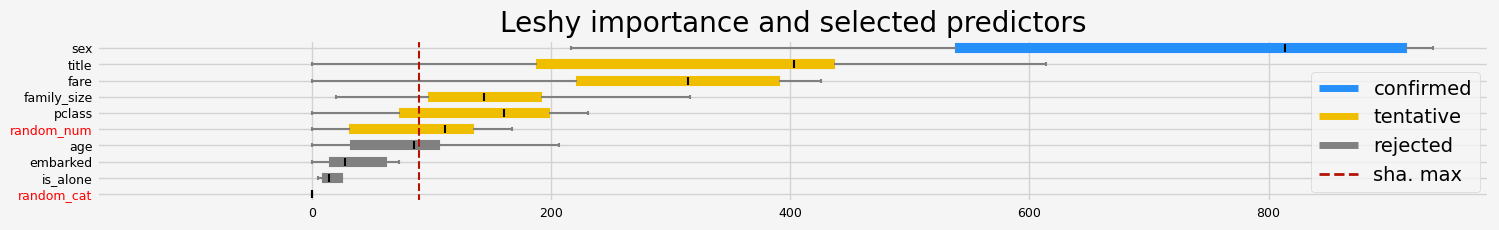

==================== Leshy - testing:             XGBClassifier for var.imp: shap            ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using shap var. imp.

Iteration: 	1 / 10
Confirmed: 	5
Tentative: 	1
Rejected: 	4
All relevant predictors selected in 00:00:01.04
['pclass' 'sex' 'embarked' 'age' 'fare']


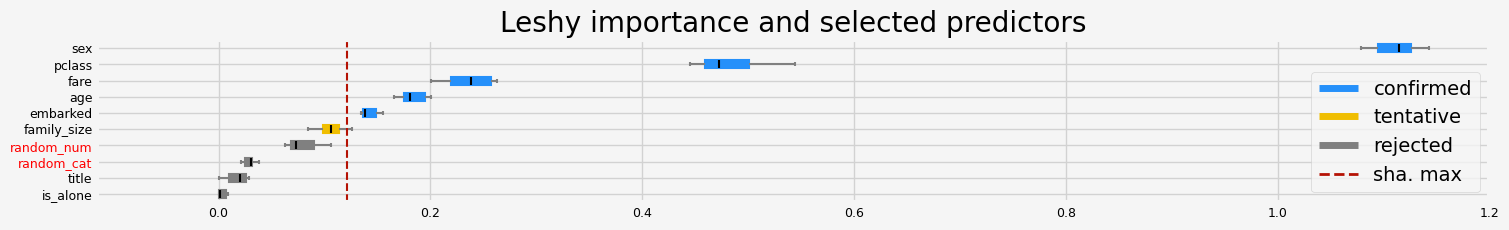

==================== Leshy - testing:             XGBClassifier for var.imp: pimp            ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using pimp var. imp.

Iteration: 	1 / 10
Confirmed: 	4
Tentative: 	1
Rejected: 	5
All relevant predictors selected in 00:00:04.14
['pclass' 'sex' 'age' 'family_size']


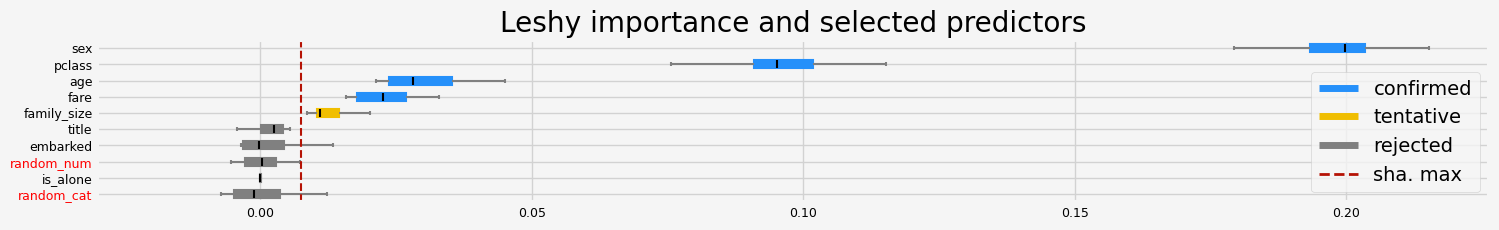

==================== Leshy - testing:             XGBClassifier for var.imp: native          ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	5
Tentative: 	2
Rejected: 	3
All relevant predictors selected in 00:00:00.69
['pclass' 'sex' 'embarked' 'title' 'family_size']


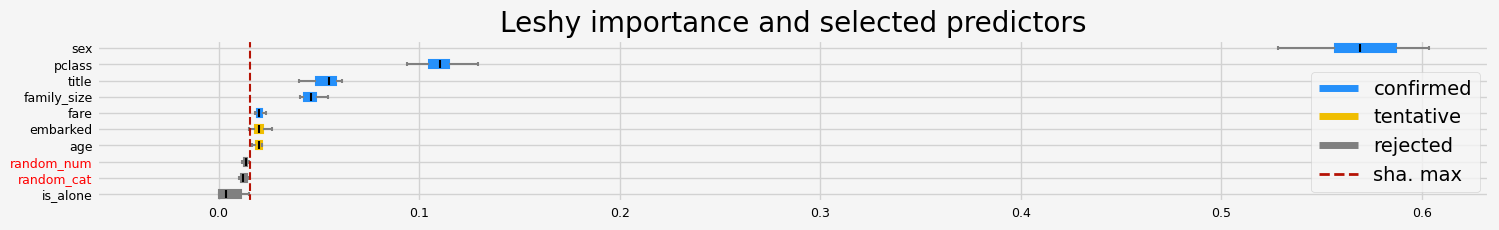

In [22]:
models = [
    # RandomForestClassifier(n_jobs=4, oob_score=False),
    CatBoostClassifier(random_state=42, verbose=0),
    LGBMClassifier(random_state=42, verbose=-1),
    LightForestClassifier(n_feat=X.shape[1]),
    XGBClassifier(random_state=42, verbosity=0, eval_metric="logloss"),
]

feat_selector = arfsgroot.Leshy(
    model, n_estimators=10, verbose=1, max_iter=10, random_state=42
)

model = LGBMClassifier(random_state=42, verbose=-1)

if __name__ == "__main__":
    # classification
    titanic = load_data(name="Titanic")
    X, y = titanic.data, titanic.target.cat.codes
    cat_f = titanic.categorical
    # running the ARFS methods using different models
    compare_varimp(feat_selector, models, X, y, sample_weight=None)

==================== Leshy - testing:    RandomForestClassifier for var.imp: shap            ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using shap var. imp.

Iteration: 	1 / 10
Confirmed: 	7
Tentative: 	1
Rejected: 	2
All relevant predictors selected in 00:00:34.85
['pclass' 'sex' 'embarked' 'title' 'age' 'family_size' 'fare']


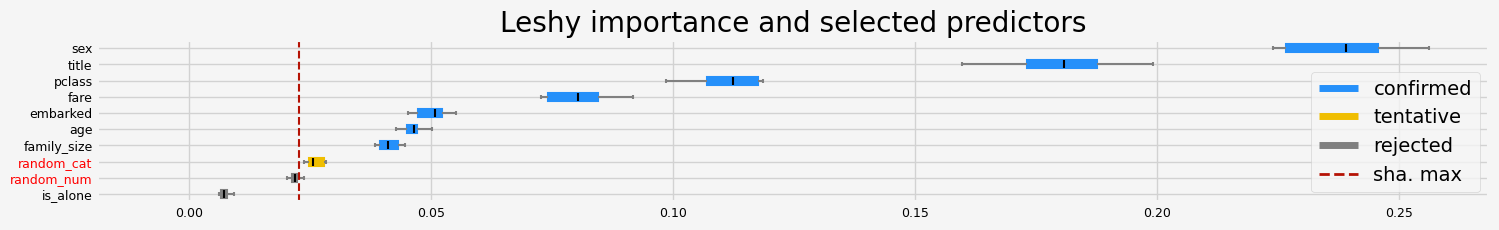

==================== Leshy - testing:    RandomForestClassifier for var.imp: pimp            ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using pimp var. imp.

Iteration: 	1 / 10
Confirmed: 	4
Tentative: 	1
Rejected: 	5
All relevant predictors selected in 00:00:24.62
['pclass' 'sex' 'title' 'family_size']


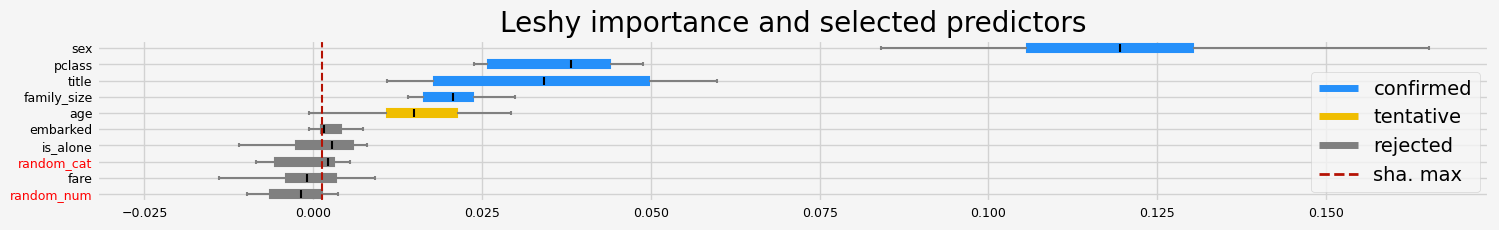

==================== Leshy - testing:    RandomForestClassifier for var.imp: native          ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	4
Tentative: 	1
Rejected: 	5
All relevant predictors selected in 00:00:05.33
['sex' 'title' 'age' 'fare']


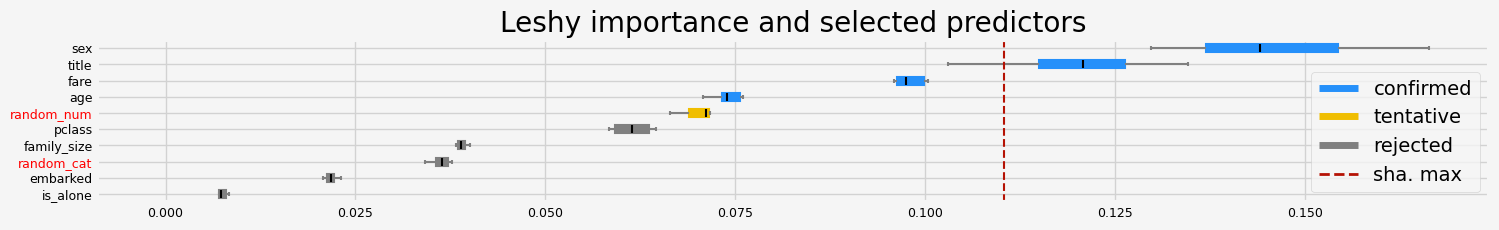

==================== Leshy - testing:        CatBoostClassifier for var.imp: shap            ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using shap var. imp.

Iteration: 	1 / 10
Confirmed: 	7
Tentative: 	0
Rejected: 	3
All relevant predictors selected in 00:00:05.59
['pclass' 'sex' 'embarked' 'title' 'age' 'family_size' 'fare']


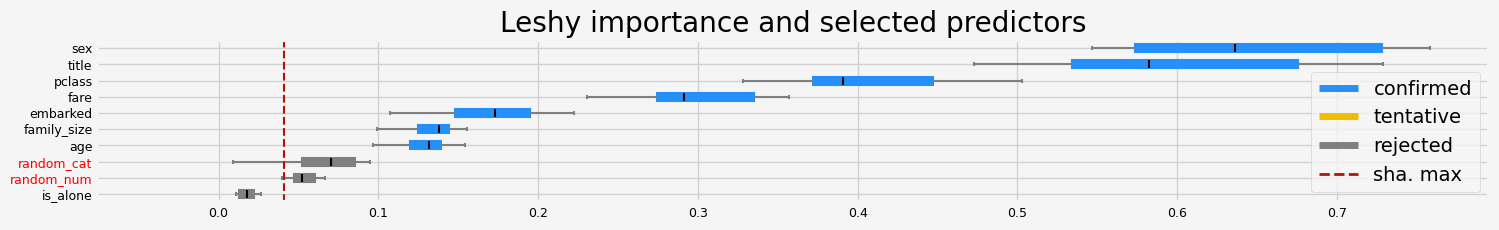

==================== Leshy - testing:        CatBoostClassifier for var.imp: pimp            ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using pimp var. imp.

Iteration: 	1 / 10
Confirmed: 	4
Tentative: 	0
Rejected: 	6
All relevant predictors selected in 00:00:07.07
['pclass' 'sex' 'title' 'family_size']


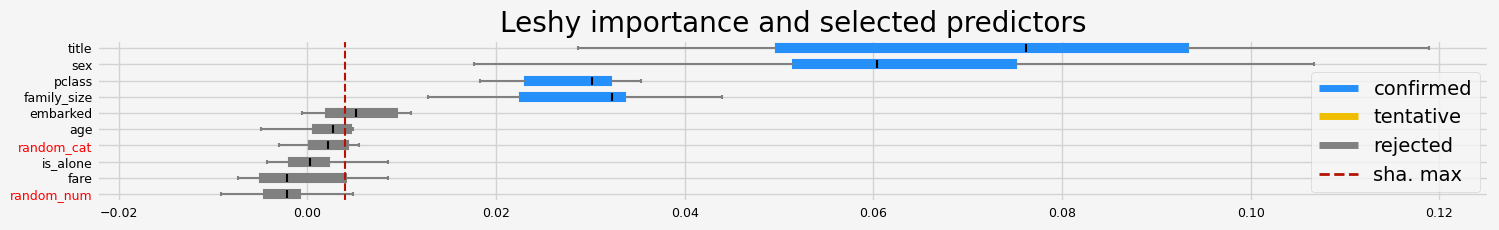

==================== Leshy - testing:        CatBoostClassifier for var.imp: native          ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	4
Tentative: 	2
Rejected: 	4
All relevant predictors selected in 00:00:04.52
['pclass' 'sex' 'title' 'fare']


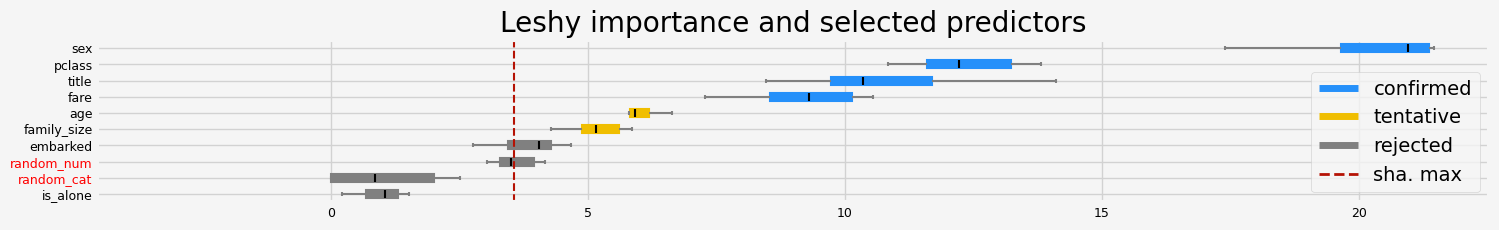

==================== Leshy - testing:            LGBMClassifier for var.imp: shap            ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]

/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/sha



Leshy finished running using shap var. imp.

Iteration: 	1 / 10
Confirmed: 	4
Tentative: 	2
Rejected: 	4
All relevant predictors selected in 00:00:03.82
['pclass' 'sex' 'age' 'fare']


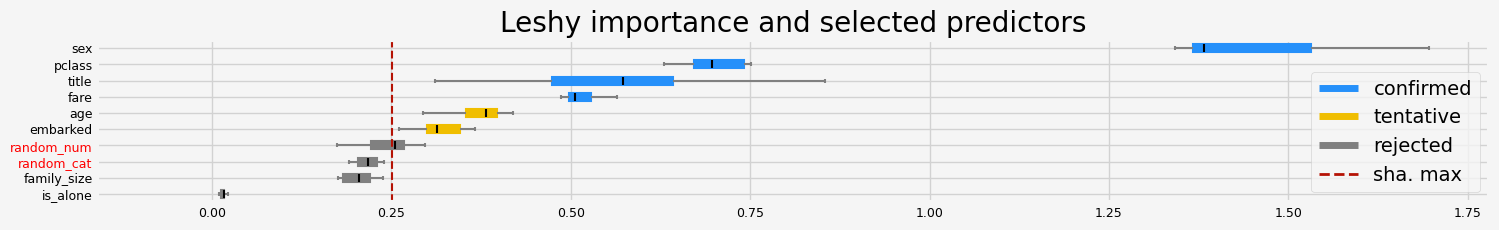

==================== Leshy - testing:            LGBMClassifier for var.imp: pimp            ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using pimp var. imp.

Iteration: 	1 / 10
Confirmed: 	3
Tentative: 	3
Rejected: 	4
All relevant predictors selected in 00:00:08.46
['pclass' 'sex' 'family_size']


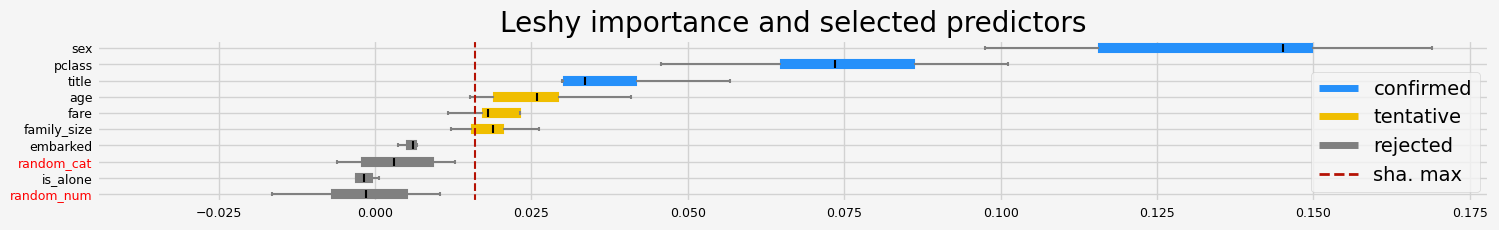

==================== Leshy - testing:            LGBMClassifier for var.imp: native          ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	2
Tentative: 	2
Rejected: 	6
All relevant predictors selected in 00:00:01.54
['sex' 'fare']


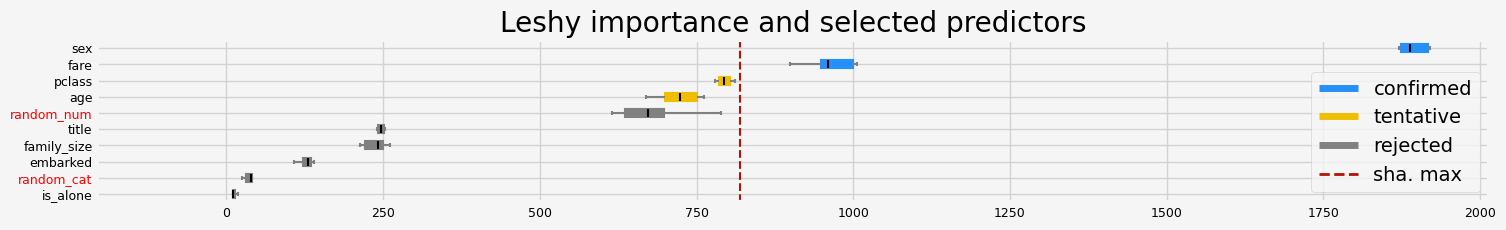

==================== Leshy - testing:            LGBMClassifier for var.imp: shap            ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]

/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/sha



Leshy finished running using shap var. imp.

Iteration: 	1 / 10
Confirmed: 	5
Tentative: 	2
Rejected: 	3
All relevant predictors selected in 00:00:02.11
['pclass' 'sex' 'embarked' 'title' 'fare']


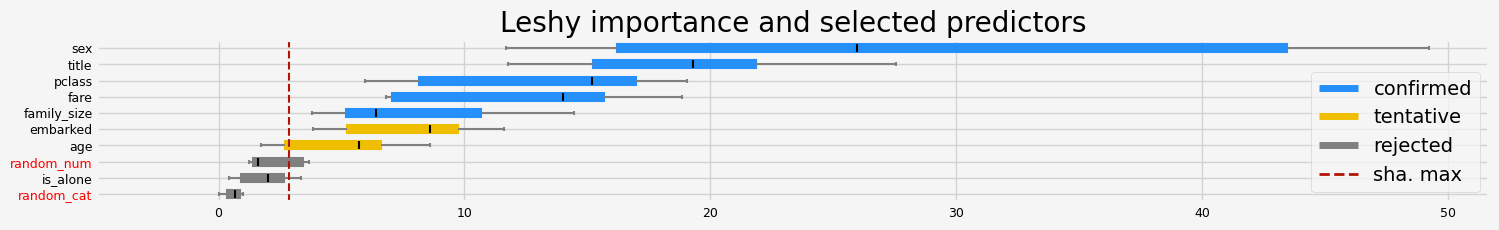

==================== Leshy - testing:            LGBMClassifier for var.imp: pimp            ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using pimp var. imp.

Iteration: 	1 / 10
Confirmed: 	2
Tentative: 	3
Rejected: 	5
All relevant predictors selected in 00:00:07.89
['sex' 'title']


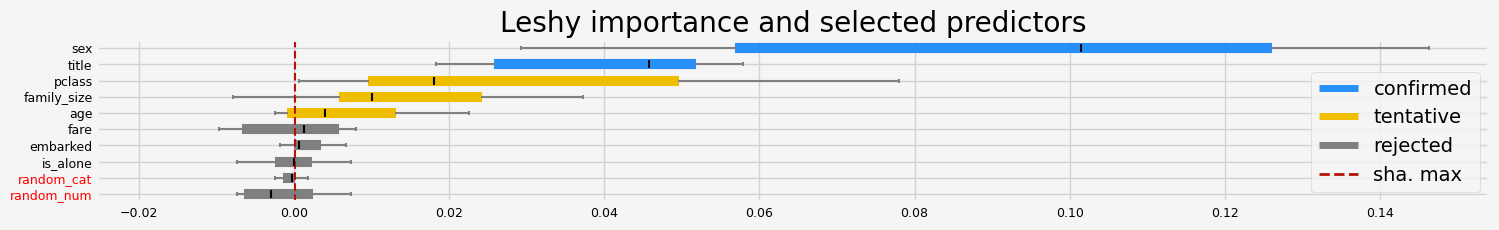

==================== Leshy - testing:            LGBMClassifier for var.imp: native          ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	4
Tentative: 	1
Rejected: 	5
All relevant predictors selected in 00:00:01.64
['pclass' 'sex' 'title' 'fare']


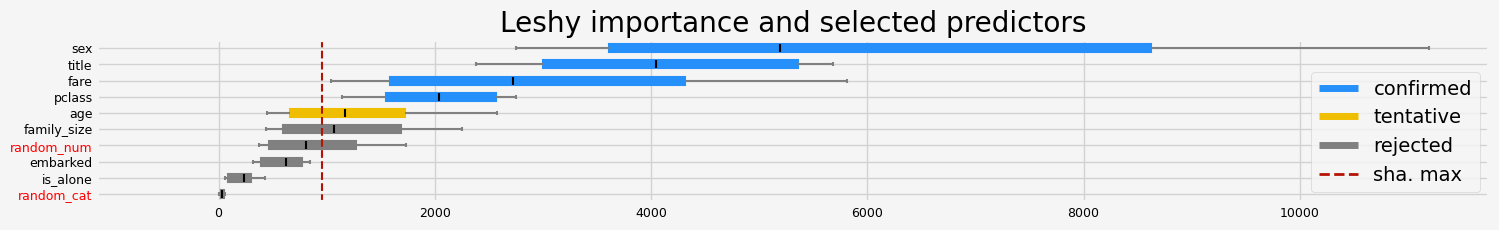

==================== Leshy - testing:             XGBClassifier for var.imp: shap            ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using shap var. imp.

Iteration: 	1 / 10
Confirmed: 	4
Tentative: 	1
Rejected: 	5
All relevant predictors selected in 00:00:03.21
['pclass' 'sex' 'age' 'fare']


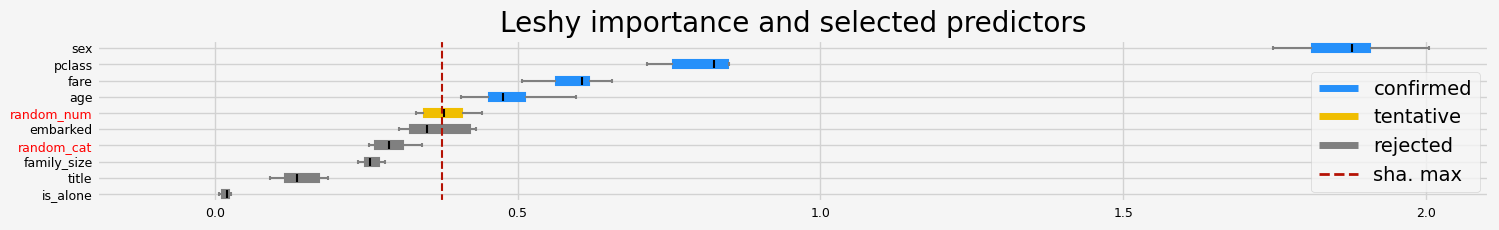

==================== Leshy - testing:             XGBClassifier for var.imp: pimp            ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using pimp var. imp.

Iteration: 	1 / 10
Confirmed: 	4
Tentative: 	2
Rejected: 	4
All relevant predictors selected in 00:00:08.42
['pclass' 'sex' 'age' 'family_size']


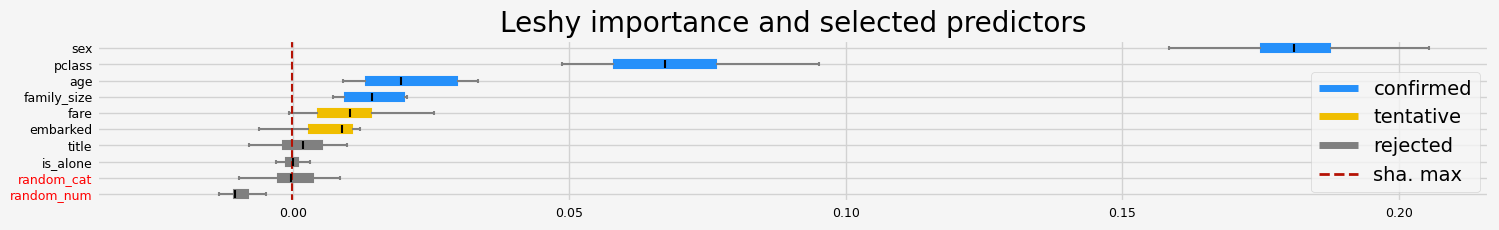

==================== Leshy - testing:             XGBClassifier for var.imp: native          ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	5
Tentative: 	2
Rejected: 	3
All relevant predictors selected in 00:00:02.00
['pclass' 'sex' 'title' 'family_size' 'fare']


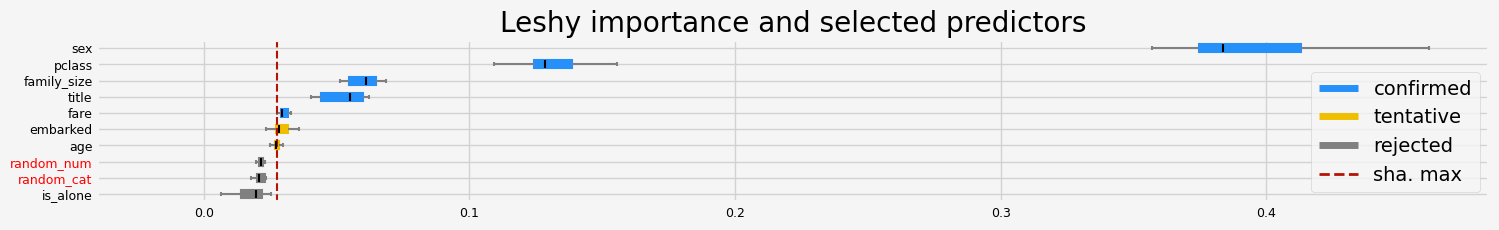

In [23]:
models = [
    RandomForestClassifier(n_jobs=4, oob_score=True),
    CatBoostClassifier(random_state=42, verbose=0),
    LGBMClassifier(random_state=42, verbose=-1),
    LightForestClassifier(n_feat=X.shape[1]),
    XGBClassifier(random_state=42, verbosity=0, eval_metric="logloss"),
]

feat_selector = arfsgroot.Leshy(
    model, n_estimators=100, verbose=1, max_iter=10, random_state=42
)

if __name__ == "__main__":
    # classification
    titanic = load_data(name="Titanic")
    X, y = titanic.data, titanic.target.cat.codes
    cat_f = titanic.categorical
    # running the ARFS methods using different models
    compare_varimp(feat_selector, models, X, y, sample_weight=None)

In [25]:
# from sklearn.datasets import make_classification
# from xgboost import XGBClassifier
# from fasttreeshap import TreeExplainer as FastTreeExplainer

# X, y = make_classification(
#     n_samples=1000, n_features=10, n_informative=8, random_state=8
# )
# model = XGBClassifier()
# model.fit(X, y)
# explainer = FastTreeExplainer(
#     model, algorithm="auto", shortcut=False, feature_perturbation="tree_path_dependent"
# )
# shap_matrix = explainer.shap_values(X)

the fasttreeshap implementation doesn't work correctly with xgboost, I created an issue

### Testing GrootCV

Cross Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[27]	training's binary_logloss: 0.262951	valid_1's binary_logloss: 0.420557
Training until validation scores don't improve for 20 rounds


/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Early stopping, best iteration is:
[17]	training's binary_logloss: 0.320217	valid_1's binary_logloss: 0.474871
Training until validation scores don't improve for 20 rounds


/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Early stopping, best iteration is:
[30]	training's binary_logloss: 0.242613	valid_1's binary_logloss: 0.384465


/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[22]	training's binary_logloss: 0.293701	valid_1's binary_logloss: 0.427967
Training until validation scores don't improve for 20 rounds


/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Early stopping, best iteration is:
[20]	training's binary_logloss: 0.295521	valid_1's binary_logloss: 0.518225
Training until validation scores don't improve for 20 rounds


/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Early stopping, best iteration is:
[26]	training's binary_logloss: 0.277771	valid_1's binary_logloss: 0.418831


/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[22]	training's binary_logloss: 0.29269	valid_1's binary_logloss: 0.447969


/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[16]	training's binary_logloss: 0.333104	valid_1's binary_logloss: 0.48861


/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[41]	training's binary_logloss: 0.192096	valid_1's binary_logloss: 0.359015


/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[19]	training's binary_logloss: 0.301622	valid_1's binary_logloss: 0.504762


/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[31]	training's binary_logloss: 0.225072	valid_1's binary_logloss: 0.461113


/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.192027	valid_1's binary_logloss: 0.465366


/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[22]	training's binary_logloss: 0.284188	valid_1's binary_logloss: 0.461567


/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[44]	training's binary_logloss: 0.179354	valid_1's binary_logloss: 0.421156


/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[24]	training's binary_logloss: 0.280802	valid_1's binary_logloss: 0.418434


/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.262687	valid_1's binary_logloss: 0.440175


/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[22]	training's binary_logloss: 0.295969	valid_1's binary_logloss: 0.409384


/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.228744	valid_1's binary_logloss: 0.445173


/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.281642	valid_1's binary_logloss: 0.46191


/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[25]	training's binary_logloss: 0.269771	valid_1's binary_logloss: 0.448045
Training until validation scores don't improve for 20 rounds


/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Early stopping, best iteration is:
[22]	training's binary_logloss: 0.301905	valid_1's binary_logloss: 0.409273
Training until validation scores don't improve for 20 rounds


/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Early stopping, best iteration is:
[25]	training's binary_logloss: 0.26923	valid_1's binary_logloss: 0.444088


/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.187609	valid_1's binary_logloss: 0.460375


/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[20]	training's binary_logloss: 0.292804	valid_1's binary_logloss: 0.479404


/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[21]	training's binary_logloss: 0.295055	valid_1's binary_logloss: 0.493018
['pclass' 'sex' 'title' 'age' 'fare']


/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


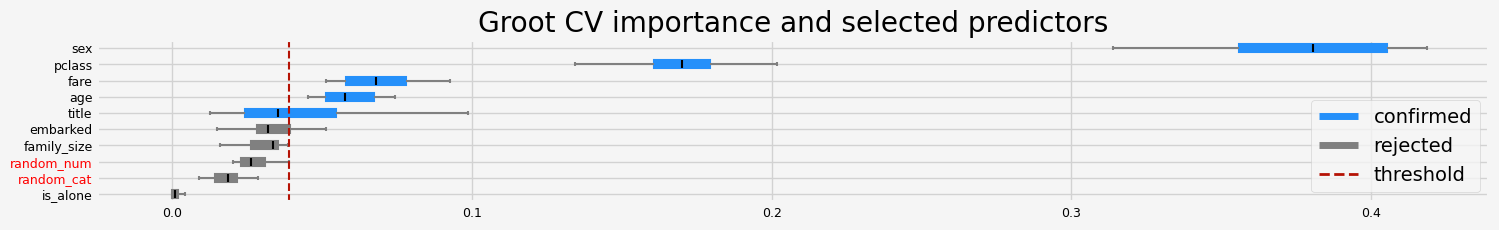

In [26]:
# Testing the changes with rnd cat. and num. predictors added to the set of genuine predictors
def testing_estimators(X, y, sample_weight=None, objective="binary"):
    feat_selector = arfsgroot.GrootCV(
        objective=objective, cutoff=1, n_folds=5, n_iter=5
    )
    feat_selector.fit(X, y, sample_weight)
    print(feat_selector.get_feature_names_out())
    fig = feat_selector.plot_importance(n_feat_per_inch=5)

    # highlight synthetic random variable
    fig = highlight_tick(figure=fig, str_match="random")
    plt.show()
    gc.enable()
    del feat_selector
    gc.collect()


if __name__ == "__main__":
    # classification
    titanic = load_data(name="Titanic")
    X, y = titanic.data, titanic.target
    y = y.astype(int)
    cat_f = titanic.categorical
    testing_estimators(X=X, y=y, objective="binary")

This confirms that the native (gini/gain) feature importance are biased and not the best to assess the real feature importance.

### Testing BoostAGroota

==================== BoostAGroota - testing:    RandomForestClassifier for var.imp: shap            ====================


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

['pclass' 'sex' 'embarked' 'random_cat' 'title' 'age' 'family_size' 'fare'
 'random_num']


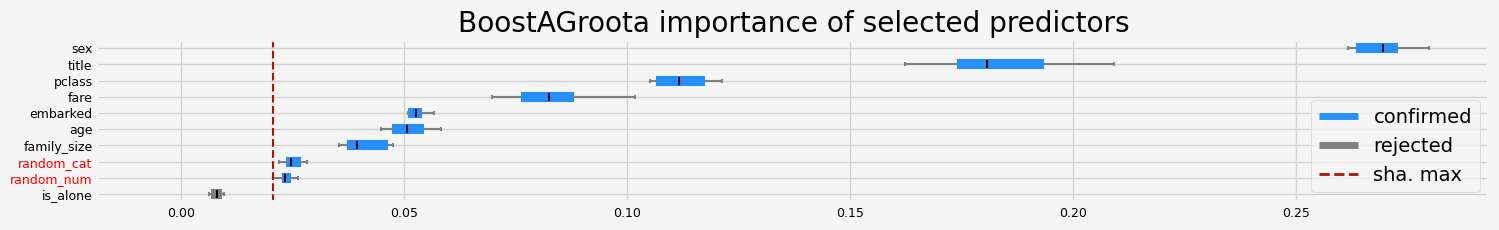

==================== BoostAGroota - testing:    RandomForestClassifier for var.imp: pimp            ====================


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

['pclass' 'sex' 'title' 'age' 'family_size']


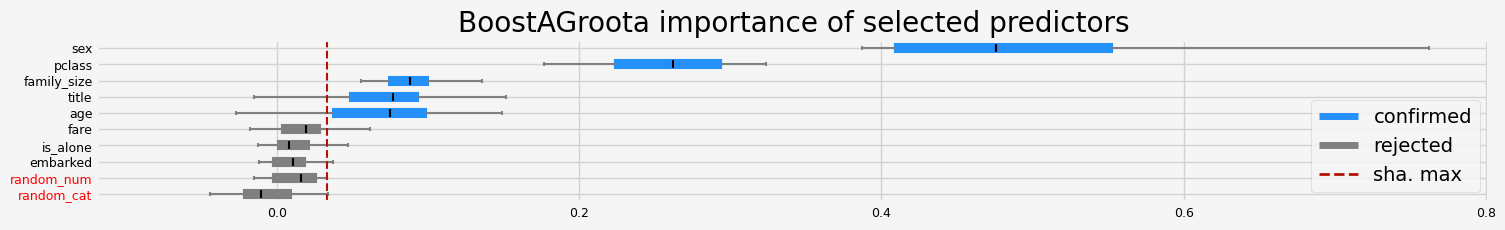

==================== BoostAGroota - testing:    RandomForestClassifier for var.imp: native          ====================


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

['pclass' 'sex' 'random_cat' 'title' 'age' 'family_size' 'fare'
 'random_num']


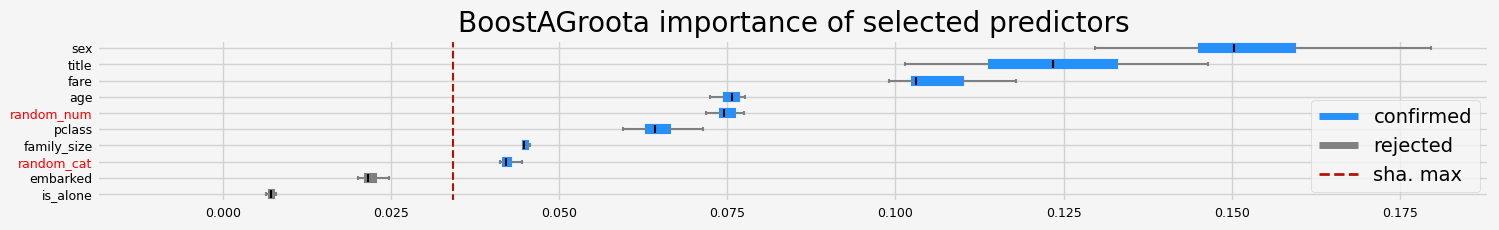

==================== BoostAGroota - testing:        CatBoostClassifier for var.imp: shap            ====================


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

['pclass' 'sex' 'embarked' 'title' 'age' 'family_size' 'fare']


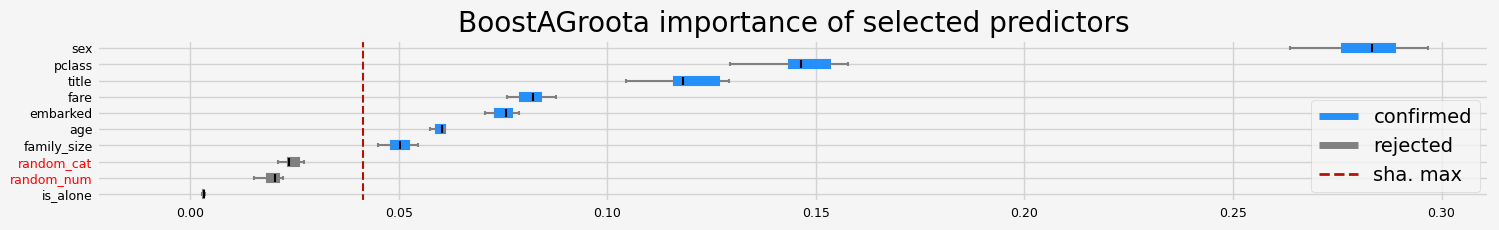

==================== BoostAGroota - testing:        CatBoostClassifier for var.imp: pimp            ====================


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

['pclass' 'sex' 'title' 'age' 'family_size']


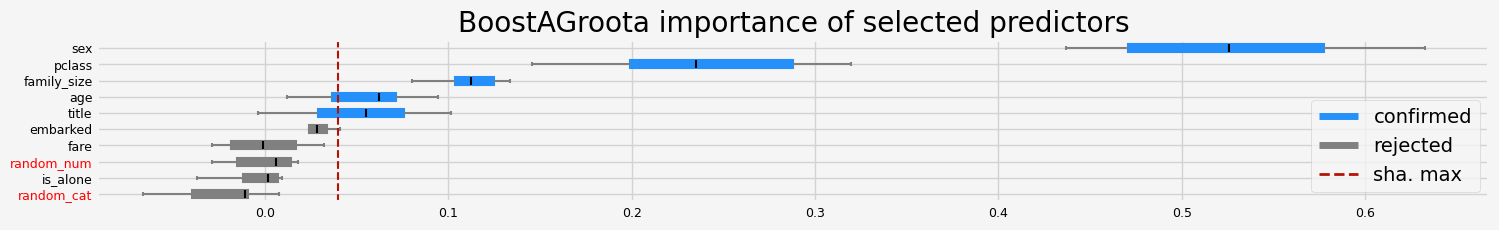

==================== BoostAGroota - testing:        CatBoostClassifier for var.imp: native          ====================


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

['pclass' 'sex' 'random_cat' 'title' 'age' 'family_size' 'fare'
 'random_num']


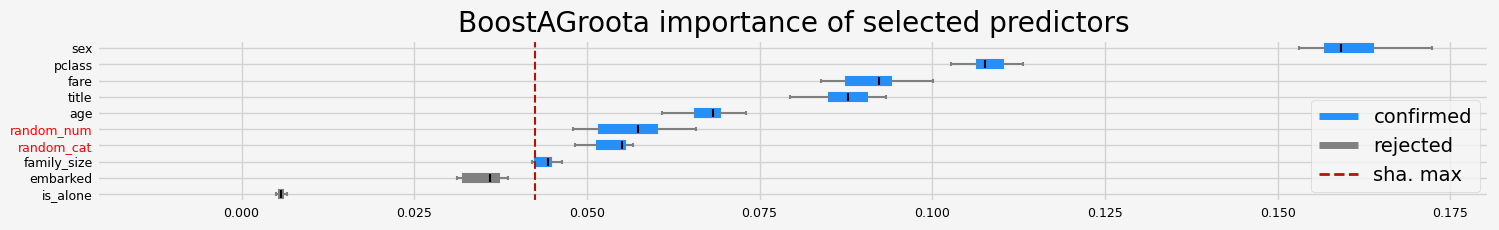

==================== BoostAGroota - testing:            LGBMClassifier for var.imp: shap            ====================


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/sha

['pclass' 'sex' 'embarked' 'age' 'family_size' 'fare' 'random_num']


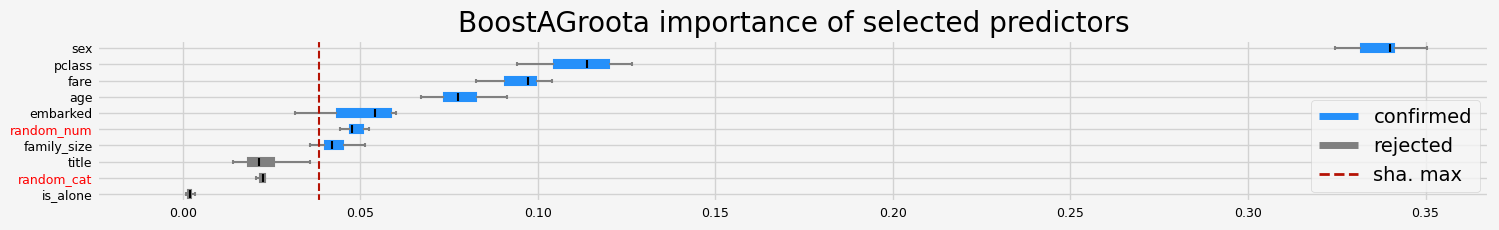

==================== BoostAGroota - testing:            LGBMClassifier for var.imp: pimp            ====================


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

['pclass' 'sex' 'age' 'family_size' 'fare']


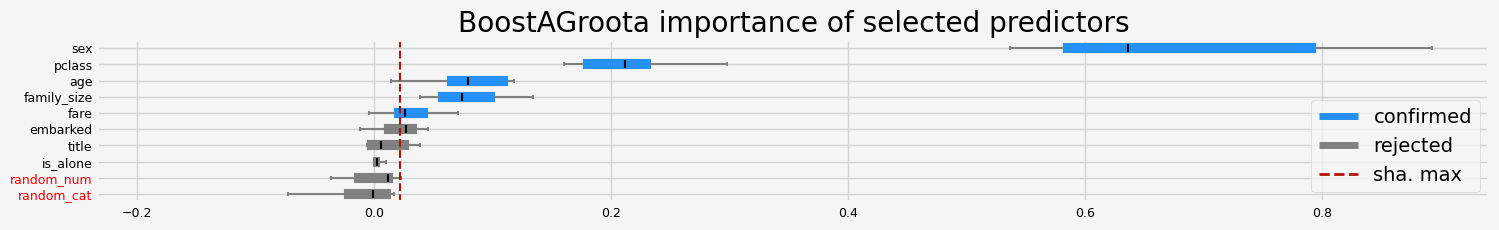

==================== BoostAGroota - testing:            LGBMClassifier for var.imp: native          ====================


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

['pclass' 'sex' 'age' 'fare' 'random_num']


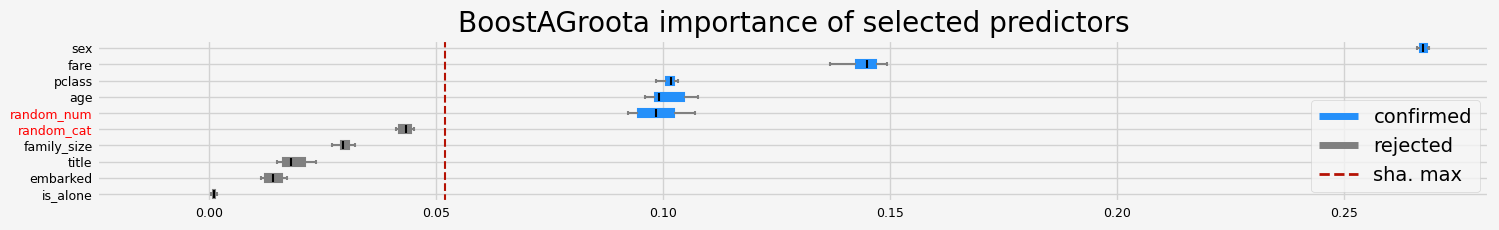

==================== BoostAGroota - testing:            LGBMClassifier for var.imp: shap            ====================


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/sha

['pclass' 'sex' 'embarked' 'title' 'family_size' 'fare']


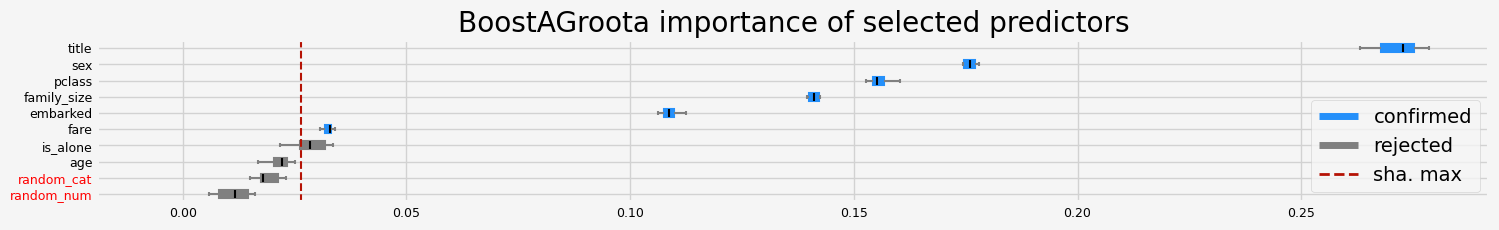

==================== BoostAGroota - testing:            LGBMClassifier for var.imp: pimp            ====================


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

['pclass' 'sex' 'title' 'fare']


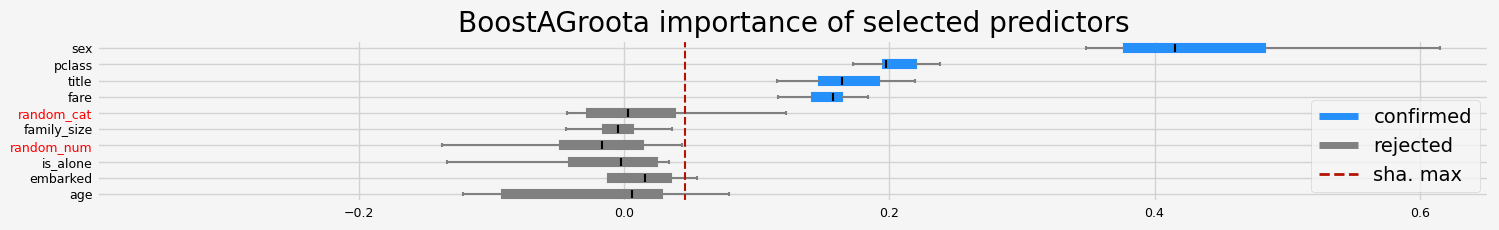

==================== BoostAGroota - testing:            LGBMClassifier for var.imp: native          ====================


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

['pclass' 'sex' 'title' 'fare']


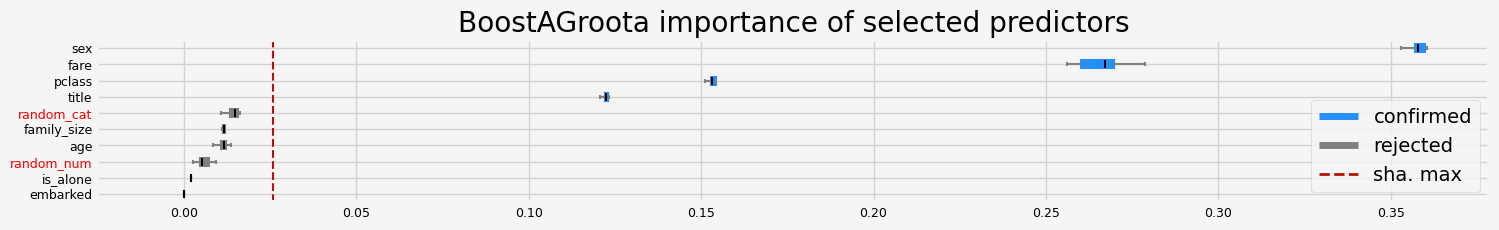

==================== BoostAGroota - testing:             XGBClassifier for var.imp: shap            ====================


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

['pclass' 'sex' 'embarked' 'age' 'fare' 'random_num']


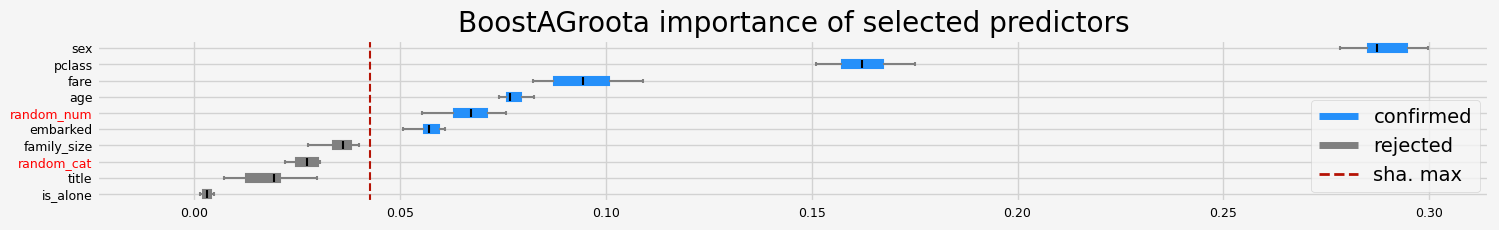

==================== BoostAGroota - testing:             XGBClassifier for var.imp: pimp            ====================


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

['pclass' 'sex' 'embarked' 'age' 'family_size' 'fare']


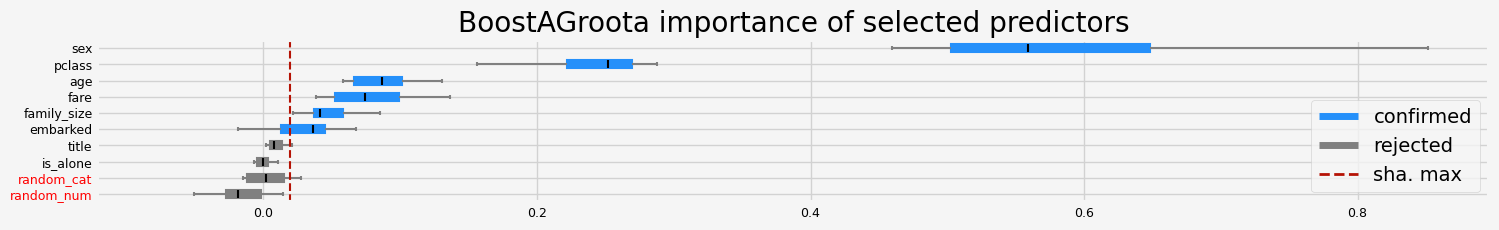

==================== BoostAGroota - testing:             XGBClassifier for var.imp: native          ====================


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

['pclass' 'sex' 'embarked' 'random_cat' 'title' 'age' 'family_size' 'fare']


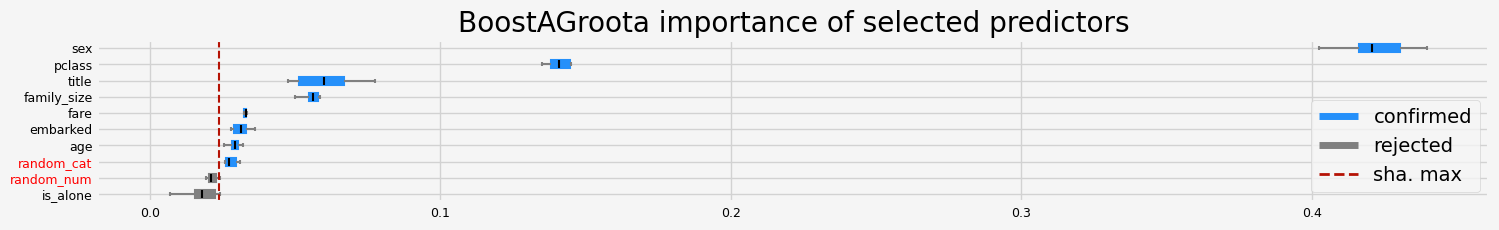

In [27]:
models = [
    RandomForestClassifier(n_jobs=4, oob_score=True),
    CatBoostClassifier(random_state=42, verbose=0),
    LGBMClassifier(random_state=42, verbose=-1),
    LightForestClassifier(n_feat=X.shape[1]),
    XGBClassifier(random_state=42, verbosity=0),
]

feat_selector = arfsgroot.BoostAGroota(
    estimator=model, cutoff=1.25, iters=10, max_rounds=10, delta=0.1
)

if __name__ == "__main__":
    # classification
    titanic = load_data(name="Titanic")
    X, y = titanic.data, titanic.target
    y = y.astype(int)
    cat_f = titanic.categorical
    # running the ARFS methods using different models
    compare_varimp(feat_selector, models, X, y, sample_weight=None)

### comparing to BorutaShap

BorutaShap is (partly) broken, has some dependencies conflicts

In [28]:
# from BorutaShap import BorutaShap
# from arfs.preprocessing import OrdinalEncoderPandas

# model = LGBMClassifier(random_state=42, verbose=-1, n_estimators=10)
# X_encoded = OrdinalEncoderPandas().fit_transform(X=X)
# Feature_Selector = BorutaShap(
#     model=model, importance_measure="shap", classification=True
# )

# Feature_Selector.fit(X=X_encoded, y=y, n_trials=100, random_state=0)

# # Returns Boxplot of features
# Feature_Selector.plot(X_size=12, figsize=(8, 6), y_scale="log", which_features="all")

Leshy iteration:   0%|          | 0/100 [00:00<?, ?it/s]

/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/sha



Leshy finished running using shap var. imp.

Iteration: 	1 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	4
All relevant predictors selected in 00:00:04.97
['pclass' 'sex' 'embarked' 'age' 'fare']


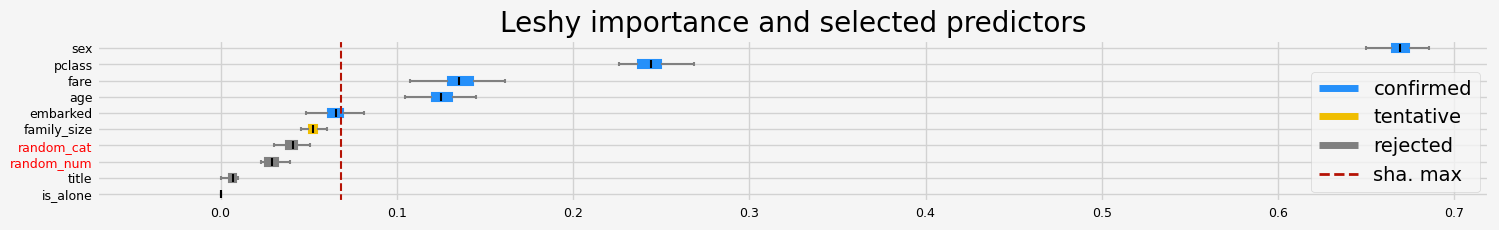

In [29]:
# Leshy
from arfs.preprocessing import OrdinalEncoderPandas

model = LGBMClassifier(random_state=42, verbose=-1, n_estimators=10)
X_encoded = OrdinalEncoderPandas().fit_transform(X=X)
feat_selector = arfsgroot.Leshy(
    model, n_estimators=10, verbose=1, max_iter=100, random_state=42, importance="shap"
)
feat_selector.fit(X_encoded, y, sample_weight=None)
print(feat_selector.get_feature_names_out())
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()